In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import PercentFormatter
from scipy.stats import mannwhitneyu, ttest_ind

# **Initial Thoughts/Ideas to Investigate:**

- Summary statistics
    - What proportion of booking are mobile?
    - Where are the mobile bookings made? (Pie chart)
    - How has this changed over time (group by week or month)? (Use linear regression)
- Hypothesis tests
    - Any specific countries using one platform above others?
    - Difference in booking windows between desktop users and mobile users? (t-test/welch's test)
    - Difference in average booking value (will need to statify by country) (boxplot)?
    - Difference in net orders?
    - Are mobile users more/less likely to travel within same country/region?

# **Further Questions:**

- Given a more precise date/time of when bookings are made, could look for trends in when mobile devices are more commonly used
- Given the Super Region associated with each Property Country, could investigate whether customers booking through mobile devices are more/less likely to travel within the same region or outside of it

In [2]:
# importing data as data frame

entire_data = pd.read_excel("expedia_dataset.xlsx")

In [3]:
entire_data

,Week,Mobile Indicator Name,Platform Type Name,Super Region,Country Name,Booking Window Group,Property Country,Net Gross Booking Value USD,Net Orders
0,2016-W45,Desktop,Desktop,APAC,South Korea,8-14 days,Algeria,-608.4244,-3
1,2016-W45,Desktop,Desktop,APAC,South Korea,+90 days,Andorra,-512.1796,-2
2,2016-W45,Desktop,Desktop,APAC,South Korea,46-60 days,Andorra,103.4298,1
3,2016-W45,Desktop,Desktop,APAC,Australia,31-45 days,Argentina,395.9592,1
4,2016-W45,Desktop,Desktop,APAC,Australia,15-30 days,Argentina,373.4194,1
...,...,...,...,...,...,...,...,...,...
73683,2017-W48,Mobile,Mobile Web,NaN,US,15-30 days,Vietnam,748.2964,6
73684,2017-W48,Mobile,Mobile Web,NaN,US,31-45 days,Vietnam,2379.9672,7
73685,2017-W48,Mobile,Mobile Web,NaN,US,46-60 days,Vietnam,66.7100,1
73686,2017-W48,Mobile,Mobile Web,NaN,US,8-14 days,Vietnam,591.3000,2


In [4]:
entire_data["Year"] = [int(list(entire_data["Week"])[x][0:4]) for x in range(len(entire_data))]
entire_data

,Week,Mobile Indicator Name,Platform Type Name,Super Region,Country Name,Booking Window Group,Property Country,Net Gross Booking Value USD,Net Orders,Year
0,2016-W45,Desktop,Desktop,APAC,South Korea,8-14 days,Algeria,-608.4244,-3,2016
1,2016-W45,Desktop,Desktop,APAC,South Korea,+90 days,Andorra,-512.1796,-2,2016
2,2016-W45,Desktop,Desktop,APAC,South Korea,46-60 days,Andorra,103.4298,1,2016
3,2016-W45,Desktop,Desktop,APAC,Australia,31-45 days,Argentina,395.9592,1,2016
4,2016-W45,Desktop,Desktop,APAC,Australia,15-30 days,Argentina,373.4194,1,2016
...,...,...,...,...,...,...,...,...,...,...
73683,2017-W48,Mobile,Mobile Web,NaN,US,15-30 days,Vietnam,748.2964,6,2017
73684,2017-W48,Mobile,Mobile Web,NaN,US,31-45 days,Vietnam,2379.9672,7,2017
73685,2017-W48,Mobile,Mobile Web,NaN,US,46-60 days,Vietnam,66.7100,1,2017
73686,2017-W48,Mobile,Mobile Web,NaN,US,8-14 days,Vietnam,591.3000,2,2017


### **Data Quality Issue**
There are **3405** instances of the data where the 'Net Orders' is a negative number. This is assummed to be data quality issue since if a customer cancels all bookings then expect 'Net Orders' to be 0.

This makes up about **4.6%** of the data, so I have chosen to **remove** them.

Another option would have been to also consider whther the 'Net Gross Booking Value USD' was positive or negative and postentially take the negative instances to be bookings that were fully cancelled (assuming that the booking were technically cancelled more than once) - in a real life situation I would have discussed this with a more experienced collegue or the person who provided the data.

In [7]:
entire_data = entire_data[entire_data['Net Orders'] >= 0]

In [8]:
(entire_data["Net Gross Booking Value USD"] < 0).sum()

3083

### **Data Quality Issue**
There are a further **3083** instances where the 'Net Gross Booking Value USD' is strictly negative.

Again, I will assume that this is because bookings have technically been cancelled more than once on the system. With the data provided, I am unable to recover the actual booking value but this could potentially be resolved given the initial number of bookings and the number of bookings cancelled and the values of each of these.

To resolve this, these instances will also be removed. At this point, around **8.8%** of the initial data has been removed.

There are also a small number of instances of cancelled bookings with very low, but non-zero 'Net Gross Booking Value USD'. I will assume that this may be due to small fares not being refunded or currency issues and leave these as is. These values are close to zero anyway so are unlikely to skew the analysis much.

In [10]:
entire_data = entire_data[entire_data['Net Gross Booking Value USD'] >= 0]

In [11]:
# seperate into desktop and mobile bookings

desktop_data = entire_data[entire_data["Mobile Indicator Name"] == "Desktop"]
mobile_data = entire_data[entire_data["Mobile Indicator Name"] == "Mobile"]
mobile_web_data = mobile_data[mobile_data["Platform Type Name"] == "Mobile Web"]
mobile_app_data = mobile_data[mobile_data["Platform Type Name"] == "Mobile App"]

In [12]:
# with pd.ExcelWriter('separated_data.xlsx') as writer:  
#     desktop_data.to_excel(writer, sheet_name='desktop')
#     mobile_data.to_excel(writer, sheet_name='mobile')
#     mobile_web_data.to_excel(writer, sheet_name='mobile_web')
#     mobile_app_data.to_excel(writer, sheet_name='mobile_app')

In [13]:
# checking there are no missing bookings

print(len(desktop_data) + len(mobile_data) == len(entire_data))
print(len(desktop_data) + len(mobile_web_data) + len(mobile_app_data) == len(entire_data))

True
True


In [14]:
print(f"Overall percentage of mobile bookings (including those which were cancelled): {100 * len(mobile_data)/len(entire_data)}%")
print(f"Out of the mobile bookings, percentage made on app: {100 * len(mobile_app_data)/len(mobile_data)}%")
print(f"Out of the mobile bookings, percentage made on web: {100 * len(mobile_web_data)/len(mobile_data)}%")

Overall percentage of mobile bookings (including those which were cancelled): 52.20982142857143%
Out of the mobile bookings, percentage made on app: 48.7416274761294%
Out of the mobile bookings, percentage made on web: 51.2583725238706%


In [15]:
#delete:
# Will start by just considering the bookings which were not cancelled, and then will conduct some analysis to see whether there are any links between device and amount of cancelled bookings

In [16]:
#delete:
# desktop_data_fullfilled = desktop_data[desktop_data["Net Orders"] > 0]
# mobile_data_fullfilled = mobile_data[mobile_data["Net Orders"] > 0]
# mobile_web_data_fullfilled = mobile_web_data[mobile_web_data["Net Orders"] > 0]
# mobile_app_data_fullfilled = mobile_app_data[mobile_app_data["Net Orders"] > 0]

## **How did the amount of mobile bookings changed between 2016 and 2017?**

In [17]:
entire_data.groupby(by=["Week"]).count()

,Mobile Indicator Name,Platform Type Name,Super Region,Country Name,Booking Window Group,Property Country,Net Gross Booking Value USD,Net Orders,Year
Week,,,,,,,,,
2016-W45,7785,7785,5667,7785,7785,7785,7785,7785,7785
2016-W46,7882,7882,5723,7882,7882,7882,7882,7882,7882
2016-W47,7633,7633,5508,7633,7633,7633,7633,7633,7633
2016-W48,7664,7664,5560,7664,7664,7664,7664,7664,7664
2017-W45,9280,9280,6791,9280,9280,9280,9280,9280,9280
2017-W46,9200,9200,6741,9200,9200,9200,9200,9200,9200
2017-W47,8794,8794,6415,8794,8794,8794,8794,8794,8794
2017-W48,8962,8962,6578,8962,8962,8962,8962,8962,8962


In [18]:
entire_data.groupby(by=["Week"]).count()["Mobile Indicator Name"].sum() == len(entire_data)

True

In [19]:
mobile_data.groupby(by=["Week"]).count()

,Mobile Indicator Name,Platform Type Name,Super Region,Country Name,Booking Window Group,Property Country,Net Gross Booking Value USD,Net Orders,Year
Week,,,,,,,,,
2016-W45,3883,3883,2782,3883,3883,3883,3883,3883,3883
2016-W46,3951,3951,2812,3951,3951,3951,3951,3951,3951
2016-W47,3812,3812,2715,3812,3812,3812,3812,3812,3812
2016-W48,3872,3872,2747,3872,3872,3872,3872,3872,3872
2017-W45,5015,5015,3619,5015,5015,5015,5015,5015,5015
2017-W46,5001,5001,3627,5001,5001,5001,5001,5001,5001
2017-W47,4713,4713,3396,4713,4713,4713,4713,4713,4713
2017-W48,4838,4838,3478,4838,4838,4838,4838,4838,4838


In [20]:
desktop_proportion = desktop_data.groupby(by=["Week"]).count()["Mobile Indicator Name"] / entire_data.groupby(by=["Week"]).count()["Mobile Indicator Name"]
mobile_proportion = mobile_data.groupby(by=["Week"]).count()["Mobile Indicator Name"] / entire_data.groupby(by=["Week"]).count()["Mobile Indicator Name"]
mobile_app_proportion = mobile_app_data.groupby(by=["Week"]).count()["Mobile Indicator Name"] / entire_data.groupby(by=["Week"]).count()["Mobile Indicator Name"]
mobile_web_proportion = mobile_web_data.groupby(by=["Week"]).count()["Mobile Indicator Name"] / entire_data.groupby(by=["Week"]).count()["Mobile Indicator Name"]

In [21]:
plt.rcParams.update({'font.size': 12})

Text(0.5, 0, 'Proportion of Each Device Type')

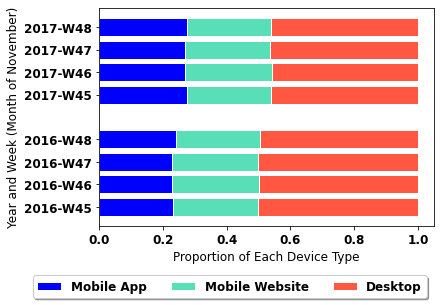

In [22]:
rc('font', weight='bold')

bars = np.add(mobile_app_proportion, mobile_web_proportion).tolist()

labels = ["2016-W45", "2016-W46", "2016-W47", "2016-W48", "2017-W45", "2017-W46", "2017-W47", "2017-W48"]
plt.barh([0,1,2,3,5,6,7,8], mobile_app_proportion, color='#0000FD', label = "Mobile App", edgecolor='white')
plt.barh([0,1,2,3,5,6,7,8], mobile_web_proportion, color='#58DFB8', left = mobile_app_proportion, label = 'Mobile Website', edgecolor='white')
plt.barh([0,1,2,3,5,6,7,8], desktop_proportion, color='#FF5741', left = bars, label = 'Desktop', edgecolor='white')
plt.legend(loc='upper center', bbox_to_anchor=(0.39, -0.2), fancybox=True, shadow=True, ncol=3)
plt.yticks([0,1,2,3,5,6,7,8], labels, fontweight='bold')
plt.ylabel("Year and Week (Month of November)")
plt.xlabel("Proportion of Each Device Type")


Conducting Mann-Whitney hypothesis test to deduce whether the proportions of mobile bookings in 2016 and 2017 are likely to come from different distributions.

This test is used since it does not assume a particular underlying ditribution such as normal.

In [23]:
mannwhitneyu(mobile_proportion[0:4], mobile_proportion[4:8], alternative="less")
# ttest_ind(mobile_proportion[0:4], mobile_proportion[4:8], equal_var=False)

MannwhitneyuResult(statistic=0.0, pvalue=0.014285714285714285)

Significant at $\alpha = 0.05$

## **Is this growth in app or website usage or both?**

In [24]:
average_app_proportions = [mobile_app_proportion[0:4].mean(), 0, mobile_app_proportion[4:8].mean(), 0]
average_web_proportions = [0, mobile_web_proportion[0:4].mean(), 0, mobile_web_proportion[4:8].mean()]

Text(0.5, 0, 'Year')

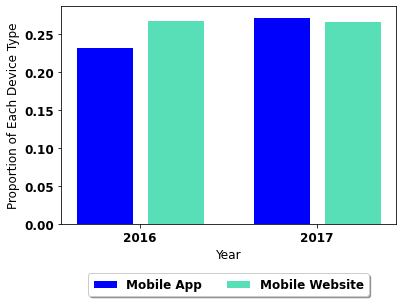

In [25]:
rc('font', weight='bold')

plt.bar([0,1,2.5,3.5], average_app_proportions, color='#0000FD', label = "Mobile App", edgecolor='white')
plt.bar([0,1,2.5,3.5], average_web_proportions, color='#58DFB8', label = "Mobile Website", edgecolor='white')
plt.xticks([0.5, 3], ["2016", "2017"], fontweight='bold')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True, ncol=3)
plt.ylabel("Proportion of Each Device Type")
plt.xlabel("Year")

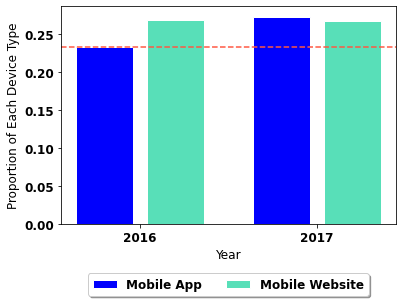

In [26]:
rc('font', weight='bold')

plt.bar([0,1,2.5,3.5], average_app_proportions, color='#0000FD', label = "Mobile App", edgecolor='white')
plt.bar([0,1,2.5,3.5], average_web_proportions, color='#58DFB8', label = "Mobile Website", edgecolor='white')
plt.xticks([0.5, 3], ["2016", "2017"], fontweight='bold')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True, ncol=3)
plt.ylabel("Proportion of Each Device Type")
plt.xlabel("Year")
plt.axhline(mobile_app_proportion[0:4].mean(), color='#FF5741', linestyle='--')
# plt.axhline(mobile_web_proportion[0:4].mean(), color='#FF5741', linestyle='--')

In [27]:
mannwhitneyu(mobile_app_proportion[0:4], mobile_app_proportion[4:8], alternative="less")

MannwhitneyuResult(statistic=0.0, pvalue=0.014285714285714285)

In [28]:
mannwhitneyu(mobile_web_proportion[0:4], mobile_web_proportion[4:8], alternative="less")

MannwhitneyuResult(statistic=11.0, pvalue=0.8285714285714285)

## **Where are the users?**

In [29]:
entire_data.groupby(by=["Super Region"]).count()

,Week,Mobile Indicator Name,Platform Type Name,Country Name,Booking Window Group,Property Country,Net Gross Booking Value USD,Net Orders,Year
Super Region,,,,,,,,,
APAC,21802,21802,21802,21802,21802,21802,21802,21802,21802
EMEA,21616,21616,21616,21616,21616,21616,21616,21616,21616
LATAM,5565,5565,5565,5565,5565,5565,5565,5565,5565


In [30]:
entire_data.groupby(by=["Super Region"]).count()["Week"].sum() == len(entire_data)

False

In [31]:
entire_data.groupby(by=["Super Region"]).count()["Week"].sum() - len(entire_data)

-18217

### **Data Quality Issue**

18217 instances do not specify the "Super Region".

Looking more closely at this shows that this is the case only for bookings made in the US and is true for all bookings made in the US.

This is fixed by adding a specific super region for the US.

In [32]:
entire_data["Super Region"] = entire_data["Super Region"].fillna("US")

In [33]:
entire_data.groupby(by=["Super Region"]).count()["Week"].sum() == len(entire_data)

True

In [34]:
entire_data.groupby(by=["Super Region"]).count()

,Week,Mobile Indicator Name,Platform Type Name,Country Name,Booking Window Group,Property Country,Net Gross Booking Value USD,Net Orders,Year
Super Region,,,,,,,,,
APAC,21802,21802,21802,21802,21802,21802,21802,21802,21802
EMEA,21616,21616,21616,21616,21616,21616,21616,21616,21616
LATAM,5565,5565,5565,5565,5565,5565,5565,5565,5565
US,18217,18217,18217,18217,18217,18217,18217,18217,18217


In [35]:
desktop_data = entire_data[entire_data["Mobile Indicator Name"] == "Desktop"]
mobile_data = entire_data[entire_data["Mobile Indicator Name"] == "Mobile"]
mobile_web_data = mobile_data[mobile_data["Platform Type Name"] == "Mobile Web"]
mobile_app_data = mobile_data[mobile_data["Platform Type Name"] == "Mobile App"]

Will only present 2017 data for the following...

In [131]:
entire_data_2017 = entire_data[entire_data["Year"]==2017]
entire_data_2016 = entire_data[entire_data["Year"]==2016]

In [37]:
desktop_data_2017 = entire_data_2017[entire_data_2017["Mobile Indicator Name"] == "Desktop"]
mobile_data_2017 = entire_data_2017[entire_data_2017["Mobile Indicator Name"] == "Mobile"]
mobile_web_data_2017 = mobile_data_2017[mobile_data_2017["Platform Type Name"] == "Mobile Web"]
mobile_app_data_2017 = mobile_data_2017[mobile_data_2017["Platform Type Name"] == "Mobile App"]

In [132]:
desktop_data_2016 = entire_data_2016[entire_data_2016["Mobile Indicator Name"] == "Desktop"]
mobile_data_2016 = entire_data_2016[entire_data_2016["Mobile Indicator Name"] == "Mobile"]
mobile_web_data_2016 = mobile_data_2016[mobile_data_2016["Platform Type Name"] == "Mobile Web"]
mobile_app_data_2016 = mobile_data_2016[mobile_data_2016["Platform Type Name"] == "Mobile App"]

In [133]:
(len(desktop_data_2017)-len(desktop_data_2016))/len(desktop_data_2016)

0.07917907548879968

In [134]:
(len(mobile_data_2017)-len(mobile_data_2016))/len(mobile_data_2016)

0.26092279932981055

In [135]:
(len(entire_data_2017)-len(entire_data_2016))/len(entire_data_2016)

0.17026224002066917

In [39]:
desktop_data_2017.groupby(by=["Super Region"]).count()["Week"]

Super Region
APAC     5248
EMEA     5553
LATAM    1604
US       4264
Name: Week, dtype: int64

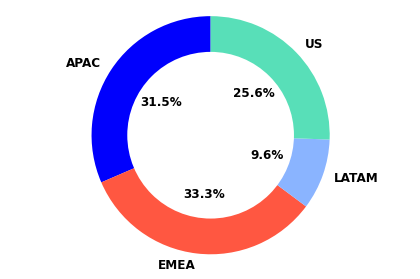

In [40]:
labels = ['APAC', 'EMEA', 'LATAM', 'US']
sizes = desktop_data_2017.groupby(by=["Super Region"]).count()["Week"]
colors = ['#0000FD','#FF5741','#8AB4FF','#58DFB8']
plt.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', pctdistance=0.5,startangle=90)

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis('equal')  
plt.tight_layout()
plt.show()

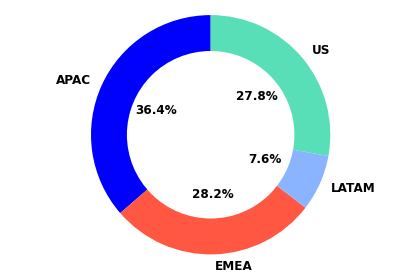

In [41]:
labels = ['APAC', 'EMEA', 'LATAM', 'US']
sizes = mobile_app_data_2017.groupby(by=["Super Region"]).count()["Week"]
colors = ['#0000FD','#FF5741','#8AB4FF','#58DFB8']
plt.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', pctdistance=0.5, startangle=90)

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis('equal')  
plt.tight_layout()
plt.show()

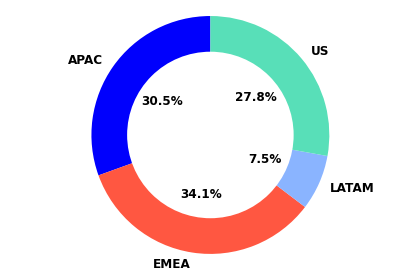

In [42]:
labels = ['APAC', 'EMEA', 'LATAM', 'US']
sizes = mobile_web_data_2017.groupby(by=["Super Region"]).count()["Week"]
colors = ['#0000FD','#FF5741','#8AB4FF','#58DFB8']
plt.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', pctdistance=0.5,startangle=90)

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis('equal')  
plt.tight_layout()
plt.show()

In [43]:
entire_data_2017_apac = entire_data_2017[entire_data_2017["Super Region"]=="APAC"]
entire_data_2017_emea = entire_data_2017[entire_data_2017["Super Region"]=="EMEA"]
entire_data_2017_latam = entire_data_2017[entire_data_2017["Super Region"]=="LATAM"]
entire_data_2017_us = entire_data_2017[entire_data_2017["Super Region"]=="US"]

In [44]:
entire_data_2017_apac.groupby(by=["Platform Type Name"]).count()["Week"]

Platform Type Name
Desktop       5248
Mobile App    3597
Mobile Web    2952
Name: Week, dtype: int64

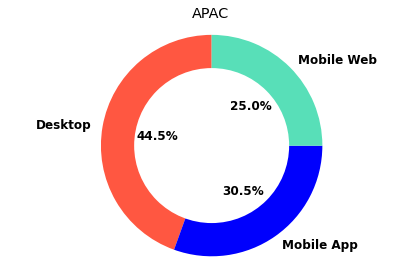

In [45]:
labels = ['Desktop', 'Mobile App', 'Mobile Web']
sizes = entire_data_2017_apac.groupby(by=["Platform Type Name"]).count()["Week"]
colors = ['#FF5741','#0000FD','#58DFB8']
plt.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', pctdistance=0.5,startangle=90)
plt.title("APAC")

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis('equal')  
plt.tight_layout()
plt.show()
# plt.title("APAc")

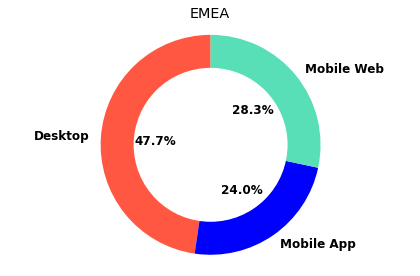

In [46]:
labels = ['Desktop', 'Mobile App', 'Mobile Web']
sizes = entire_data_2017_emea.groupby(by=["Platform Type Name"]).count()["Week"]
colors = ['#FF5741','#0000FD','#58DFB8']
plt.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', pctdistance=0.5,startangle=90)
plt.title("EMEA")

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis('equal')  
plt.tight_layout()
plt.show()

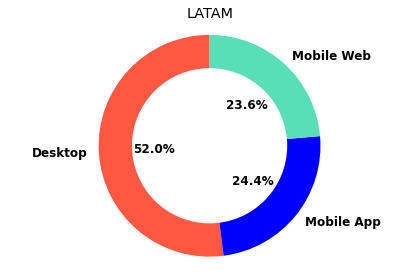

In [47]:
labels = ['Desktop', 'Mobile App', 'Mobile Web']
sizes = entire_data_2017_latam.groupby(by=["Platform Type Name"]).count()["Week"]
colors = ['#FF5741','#0000FD','#58DFB8']
plt.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', pctdistance=0.5,startangle=90)
plt.title("LATAM")

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis('equal')  
plt.tight_layout()
plt.show()

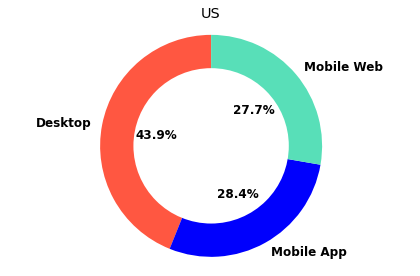

In [48]:
labels = ['Desktop', 'Mobile App', 'Mobile Web']
sizes = entire_data_2017_us.groupby(by=["Platform Type Name"]).count()["Week"]
colors = ['#FF5741','#0000FD','#58DFB8']
plt.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', pctdistance=0.5,startangle=90)
plt.title("US")

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis('equal')  
plt.tight_layout()
plt.show()

## **Any particular countries using particular platforms?**

In [49]:
entire_data.groupby(by=["Country Name"]).count()

,Week,Mobile Indicator Name,Platform Type Name,Super Region,Booking Window Group,Property Country,Net Gross Booking Value USD,Net Orders,Year
Country Name,,,,,,,,,
Australia,6735,6735,6735,6735,6735,6735,6735,6735,6735
Brazil,5565,5565,5565,5565,5565,5565,5565,5565,5565
Hong Kong,6029,6029,6029,6029,6029,6029,6029,6029,6029
Norway,7986,7986,7986,7986,7986,7986,7986,7986,7986
South Korea,9038,9038,9038,9038,9038,9038,9038,9038,9038
US,18217,18217,18217,18217,18217,18217,18217,18217,18217
United Kingdom,13630,13630,13630,13630,13630,13630,13630,13630,13630


In [50]:
entire_data_2017_australia = entire_data_2017[entire_data_2017["Country Name"]=="Australia"]
entire_data_2017_brazil = entire_data_2017[entire_data_2017["Country Name"]=="Brazil"]
entire_data_2017_hk = entire_data_2017[entire_data_2017["Country Name"]=="Hong Kong"]
entire_data_2017_norway = entire_data_2017[entire_data_2017["Country Name"]=="Norway"]
entire_data_2017_sk = entire_data_2017[entire_data_2017["Country Name"]=="South Korea"]
entire_data_2017_uk = entire_data_2017[entire_data_2017["Country Name"]=="United Kingdom"]

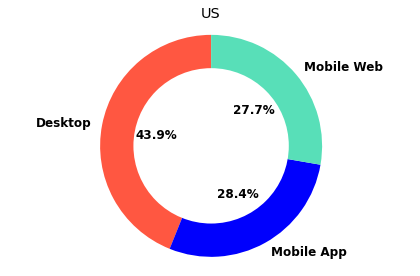

In [51]:
labels = ['Desktop', 'Mobile App', 'Mobile Web']
sizes = entire_data_2017_us.groupby(by=["Platform Type Name"]).count()["Week"]
colors = ['#FF5741','#0000FD','#58DFB8']
plt.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', pctdistance=0.5,startangle=90)
plt.title("US")

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis('equal')  
plt.tight_layout()
plt.show()

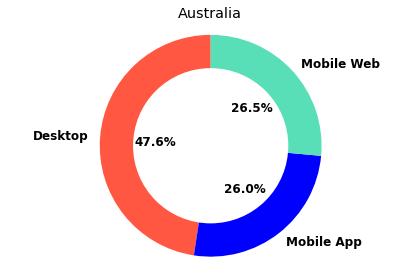

In [52]:
labels = ['Desktop', 'Mobile App', 'Mobile Web']
sizes = entire_data_2017_australia.groupby(by=["Platform Type Name"]).count()["Week"]
colors = ['#FF5741','#0000FD','#58DFB8']
plt.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', pctdistance=0.5,startangle=90)
plt.title("Australia")

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis('equal')  
plt.tight_layout()
plt.show()

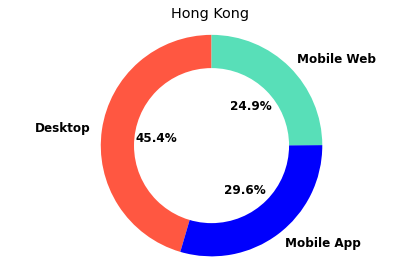

In [53]:
labels = ['Desktop', 'Mobile App', 'Mobile Web']
sizes = entire_data_2017_hk.groupby(by=["Platform Type Name"]).count()["Week"]
colors = ['#FF5741','#0000FD','#58DFB8']
plt.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', pctdistance=0.5,startangle=90)
plt.title("Hong Kong")

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis('equal')  
plt.tight_layout()
plt.show()

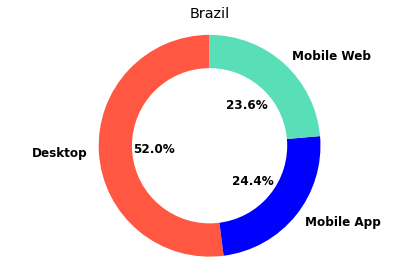

In [54]:
labels = ['Desktop', 'Mobile App', 'Mobile Web']
sizes = entire_data_2017_brazil.groupby(by=["Platform Type Name"]).count()["Week"]
colors = ['#FF5741','#0000FD','#58DFB8']
explode = (0.1, 0, 0)  
plt.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', pctdistance=0.5,startangle=90)
plt.title("Brazil")

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis('equal')  
plt.tight_layout()
plt.show()

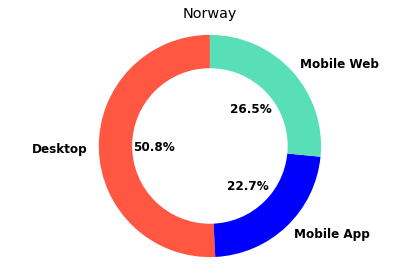

In [55]:
labels = ['Desktop', 'Mobile App', 'Mobile Web']
sizes = entire_data_2017_norway.groupby(by=["Platform Type Name"]).count()["Week"]
colors = ['#FF5741','#0000FD','#58DFB8']
plt.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', pctdistance=0.5,startangle=90)
plt.title("Norway")

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis('equal')  
plt.tight_layout()
plt.show()

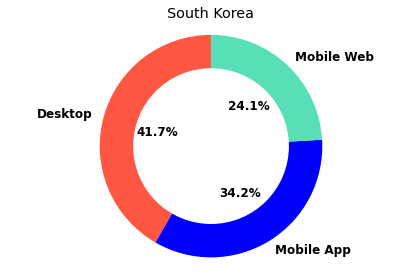

In [56]:
labels = ['Desktop', 'Mobile App', 'Mobile Web']
sizes = entire_data_2017_sk.groupby(by=["Platform Type Name"]).count()["Week"]
colors = ['#FF5741','#0000FD','#58DFB8']
plt.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', pctdistance=0.5,startangle=90)
plt.title("South Korea")

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis('equal')  
plt.tight_layout()
plt.show()

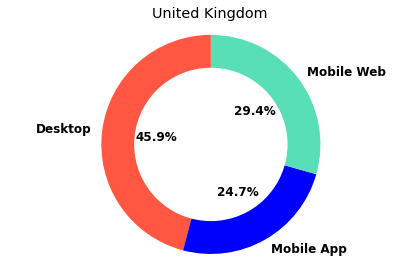

In [57]:
labels = ['Desktop', 'Mobile App', 'Mobile Web']
sizes = entire_data_2017_uk.groupby(by=["Platform Type Name"]).count()["Week"]
colors = ['#FF5741','#0000FD','#58DFB8']
plt.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', pctdistance=0.5,startangle=90)
plt.title("United Kingdom")

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis('equal')  
plt.tight_layout()
plt.show()

## **Significant difference in booking windows? (will use both 2016 and 2017)**

In [58]:
# checking for na "Booking Window Group" values
entire_data.groupby(by=["Booking Window Group"]).count()["Week"].sum() == len(entire_data)

True

In [59]:
len(desktop_data) + len(mobile_data) == len(entire_data)

True

In [60]:
# ignoring "post book"
booking_window_labels = ["0-1 days", "2-3 days", "4-7 days", "8-14 days", "15-30 days", "31-45 days", "46-60 days", "61-90 days", "+90 days"]

In [63]:
desktop_data.groupby(by=["Booking Window Group"]).count()

,Week,Mobile Indicator Name,Platform Type Name,Super Region,Country Name,Property Country,Net Gross Booking Value USD,Net Orders,Year
Booking Window Group,,,,,,,,,
+90 days,3511,3511,3511,3511,3511,3511,3511,3511,3511
0-1 days,3446,3446,3446,3446,3446,3446,3446,3446,3446
15-30 days,4098,4098,4098,4098,4098,4098,4098,4098,4098
2-3 days,3458,3458,3458,3458,3458,3458,3458,3458,3458
31-45 days,3649,3649,3649,3649,3649,3649,3649,3649,3649
4-7 days,3773,3773,3773,3773,3773,3773,3773,3773,3773
46-60 days,3197,3197,3197,3197,3197,3197,3197,3197,3197
61-90 days,3058,3058,3058,3058,3058,3058,3058,3058,3058
8-14 days,3910,3910,3910,3910,3910,3910,3910,3910,3910


In [64]:
desktop_booking_windows = [3446,3458,3773,3910,4098,3649,3197,3058,3511]

In [65]:
sum(desktop_booking_windows) == len(desktop_data) - 15

True

In [66]:
mobile_data.groupby(by=["Booking Window Group"]).count()

,Week,Mobile Indicator Name,Platform Type Name,Super Region,Country Name,Property Country,Net Gross Booking Value USD,Net Orders,Year
Booking Window Group,,,,,,,,,
+90 days,3461,3461,3461,3461,3461,3461,3461,3461,3461
0-1 days,5763,5763,5763,5763,5763,5763,5763,5763,5763
15-30 days,4163,4163,4163,4163,4163,4163,4163,4163,4163
2-3 days,4397,4397,4397,4397,4397,4397,4397,4397,4397
31-45 days,3654,3654,3654,3654,3654,3654,3654,3654,3654
4-7 days,4093,4093,4093,4093,4093,4093,4093,4093,4093
46-60 days,2963,2963,2963,2963,2963,2963,2963,2963,2963
61-90 days,2785,2785,2785,2785,2785,2785,2785,2785,2785
8-14 days,3782,3782,3782,3782,3782,3782,3782,3782,3782


In [67]:
mobile_booking_windows = [5763,4397,4093,3782,4163,3654,2963,2785,3461]

In [68]:
sum(mobile_booking_windows) == len(mobile_data) - 24

True

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

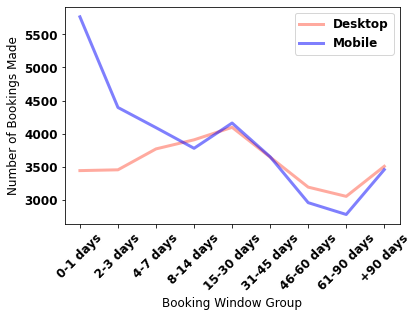

In [69]:

rc('font', weight='bold')
plt.plot(booking_window_labels, desktop_booking_windows, alpha=0.5, label='Desktop', color='#FF5741', linewidth=3)
plt.plot(booking_window_labels, mobile_booking_windows, alpha=0.5, label='Mobile', color='#0000FD', linewidth=3)
plt.legend()
plt.xlabel("Booking Window Group")
plt.ylabel("Number of Bookings Made")
# plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
# plt.title("Histogram of Correlation Coefficients of Variance of \n the Heart Rates of Instances in Cohort 1 and Cohort 2")
plt.xticks(rotation = 45)

In [70]:
mannwhitneyu(desktop_booking_windows, mobile_booking_windows)

MannwhitneyuResult(statistic=29.0, pvalue=0.331387096247615)

In [71]:
sum(desktop_booking_windows)

32100

In [72]:
sum(mobile_booking_windows)

35061

## **Differences in average booking value?**

First will create a column of "Net Gross Booking Value USD"/"Net Orders" to obtain average price paid per traveller:

In [73]:
desktop_data_not_cancelled = desktop_data[desktop_data["Net Orders"]>0]
mobile_data_not_cancelled = mobile_data[mobile_data["Net Orders"]>0]

In [74]:
desktop_data_not_cancelled["Booking Value Per Person"] = desktop_data_not_cancelled["Net Gross Booking Value USD"]/desktop_data_not_cancelled["Net Orders"]
mobile_data_not_cancelled["Booking Value Per Person"] = mobile_data_not_cancelled["Net Gross Booking Value USD"]/mobile_data_not_cancelled["Net Orders"]

/var/folders/kc/f1zxp47n4qq72801tc5mdhtw0000gn/T/ipykernel_42742/3449700816.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desktop_data_not_cancelled["Booking Value Per Person"] = desktop_data_not_cancelled["Net Gross Booking Value USD"]/desktop_data_not_cancelled["Net Orders"]
/var/folders/kc/f1zxp47n4qq72801tc5mdhtw0000gn/T/ipykernel_42742/3449700816.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mobile_data_not_cancelled["Booking Value Per Person"] = mobile_data_not_cancelled["Net Gross Booking

Text(0, 0.5, 'Net Gross Booking Value Per Person USD')

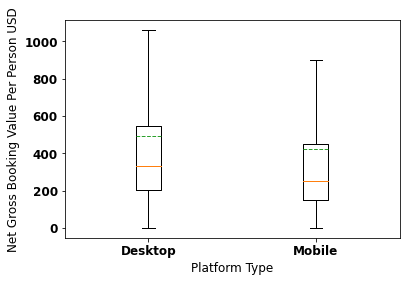

In [78]:
plt.boxplot([desktop_data_not_cancelled["Booking Value Per Person"], mobile_data_not_cancelled["Booking Value Per Person"]], showfliers=False, meanline=True, showmeans=True)
plt.xticks([1, 2], ["Desktop", "Mobile"])
# plt.legend()
# plt.boxplot(mobile_data_not_cancelled["Booking Value Per Person"])
plt.xlabel("Platform Type")
plt.ylabel("Net Gross Booking Value Per Person USD")

(array([3.1389e+04, 1.7550e+03, 3.7200e+02, 1.4400e+02, 5.4000e+01,
        3.1000e+01, 1.7000e+01, 7.0000e+00, 9.0000e+00, 8.0000e+00,
        3.0000e+00, 3.0000e+00, 3.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        2.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

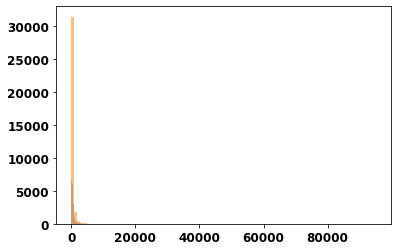

In [79]:
plt.hist(desktop_data_not_cancelled["Booking Value Per Person"], bins=100, alpha=0.5)
plt.hist(mobile_data_not_cancelled["Booking Value Per Person"], bins=100, alpha=0.5)

In [80]:
ttest_ind(desktop_data_not_cancelled["Booking Value Per Person"], mobile_data_not_cancelled["Booking Value Per Person"], equal_var=False)

Ttest_indResult(statistic=9.494603755536438, pvalue=2.298665624263459e-21)

In [81]:
print(len(mobile_data_not_cancelled), len(desktop_data_not_cancelled))

33816 31075


Now testing without the outliers

In [82]:
desktop_data_not_cancelled_no_outliers = list(desktop_data_not_cancelled["Booking Value Per Person"])
mu = np.mean(desktop_data_not_cancelled_no_outliers)
q3, q1 = np.percentile(desktop_data_not_cancelled_no_outliers, [75 ,25])
iqr = q3 - q1
desktop_outliers = []
for i, x in enumerate(desktop_data_not_cancelled_no_outliers):
    if abs(x-mu) > 1.5*iqr:
        desktop_outliers.append(x)
        desktop_data_not_cancelled_no_outliers[i] = mu

In [83]:
mobile_data_not_cancelled_no_outliers = list(mobile_data_not_cancelled["Booking Value Per Person"])
mu = np.mean(mobile_data_not_cancelled_no_outliers)
q3, q1 = np.percentile(mobile_data_not_cancelled_no_outliers, [75 ,25])
iqr = q3 - q1
mobile_outliers = []
for i, x in enumerate(mobile_data_not_cancelled_no_outliers):
    if abs(x-mu) > 1.5*iqr:
        mobile_outliers.append(x)
        mobile_data_not_cancelled_no_outliers[i] = mu

Text(0, 0.5, 'Net Gross Booking Value Per Person USD')

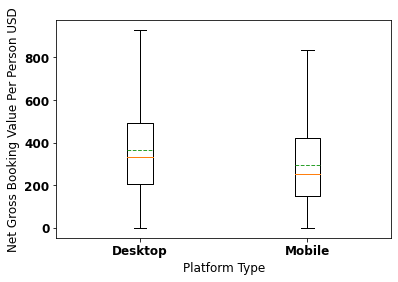

In [84]:
plt.boxplot([desktop_data_not_cancelled_no_outliers, mobile_data_not_cancelled_no_outliers], showfliers=False, meanline=True, showmeans=True)
plt.xticks([1, 2], ["Desktop", "Mobile"])
# plt.legend()
# plt.boxplot(mobile_data_not_cancelled["Booking Value Per Person"])
plt.xlabel("Platform Type")
plt.ylabel("Net Gross Booking Value Per Person USD")

In [85]:
ttest_ind(desktop_data_not_cancelled_no_outliers, mobile_data_not_cancelled_no_outliers, equal_var=False)

Ttest_indResult(statistic=45.74706962831257, pvalue=0.0)

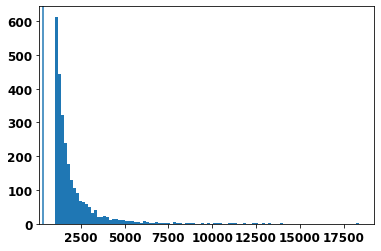

In [86]:
plt.hist(desktop_outliers, bins=100)
plt.axvline(np.mean(desktop_data_not_cancelled_no_outliers))

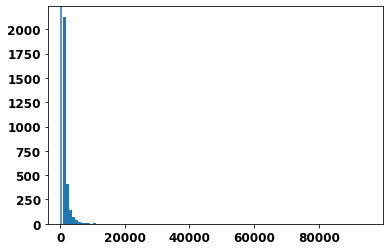

In [87]:
plt.hist(mobile_outliers, bins=100)
plt.axvline(np.mean(mobile_data_not_cancelled_no_outliers))

Text(0, 0.5, 'Net Gross Booking Value Per Person USD')

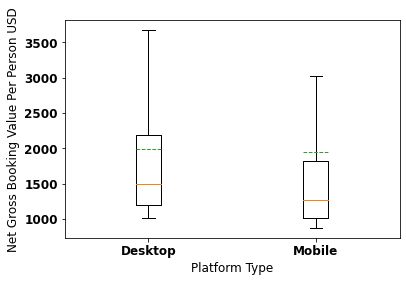

In [88]:
plt.boxplot([desktop_outliers, mobile_outliers], showfliers=False, meanline=True, showmeans=True)
plt.xticks([1, 2], ["Desktop", "Mobile"])
# plt.legend()
# plt.boxplot(mobile_data_not_cancelled["Booking Value Per Person"])
plt.xlabel("Platform Type")
plt.ylabel("Net Gross Booking Value Per Person USD")

## **Travelling within same country?**

### **Data Quality Issue**

"Property Country" uses United States of America and United Kingdom whereas "Country Name" uses US and UK

In [89]:
entire_data.replace(to_replace="United States of America", value="US", inplace=True)
entire_data.replace(to_replace="United Kingdom", value="UK", inplace=True)

In [90]:
same_country = entire_data[entire_data["Country Name"] == entire_data["Property Country"]]

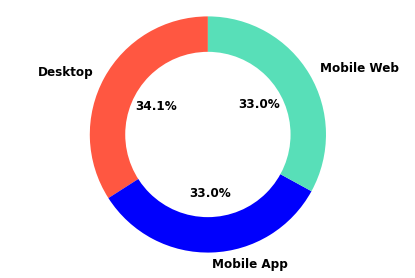

In [91]:
labels = ['Desktop', 'Mobile App', 'Mobile Web']
sizes = same_country.groupby(by=["Platform Type Name"]).count()["Week"]
colors = ['#FF5741','#0000FD','#58DFB8']
plt.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', pctdistance=0.5,startangle=90)
# plt.title("Norway")

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis('equal')  
plt.tight_layout()
plt.show()

In [92]:
same_country.groupby(by=["Super Region"]).count()

,Week,Mobile Indicator Name,Platform Type Name,Country Name,Booking Window Group,Property Country,Net Gross Booking Value USD,Net Orders,Year
Super Region,,,,,,,,,
APAC,598,598,598,598,598,598,598,598,598
EMEA,427,427,427,427,427,427,427,427,427
LATAM,214,214,214,214,214,214,214,214,214
US,238,238,238,238,238,238,238,238,238


### **Differences in net orders? (number of people being booked for)**

In [93]:
desktop_data.groupby(by=["Net Orders"]).count()

,Week,Mobile Indicator Name,Platform Type Name,Super Region,Country Name,Booking Window Group,Property Country,Net Gross Booking Value USD,Year
Net Orders,,,,,,,,,
0,1040,1040,1040,1040,1040,1040,1040,1040,1040
1,7831,7831,7831,7831,7831,7831,7831,7831,7831
2,3684,3684,3684,3684,3684,3684,3684,3684,3684
3,2535,2535,2535,2535,2535,2535,2535,2535,2535
4,1791,1791,1791,1791,1791,1791,1791,1791,1791
...,...,...,...,...,...,...,...,...,...
59226,1,1,1,1,1,1,1,1,1
61181,1,1,1,1,1,1,1,1,1
61232,1,1,1,1,1,1,1,1,1


### **Data Quality Issue**

Some anomalous net order values of 10s of thousands

Will remove any instance with a net order size greater than 300

In [122]:
desktop_data_net = desktop_data[desktop_data["Net Orders"] < 10]
mobile_data_net = mobile_data[mobile_data["Net Orders"] < 10]

desktop_data_net = desktop_data_net[desktop_data_net["Net Orders"] > 0]
mobile_data_net = mobile_data_net[mobile_data_net["Net Orders"] > 0]

In [123]:
desktop_data_net_large = desktop_data[desktop_data["Net Orders"] > 9]
mobile_data_net_large = mobile_data[mobile_data["Net Orders"] > 9]

desktop_data_net_large = desktop_data_net_large[desktop_data_net_large["Net Orders"] < 100]
mobile_data_net_large = mobile_data_net_large[mobile_data_net_large["Net Orders"] < 100]

In [124]:
desktop_data_net.groupby(by=["Net Orders"]).count()["Week"]

Net Orders
1    7831
2    3684
3    2535
4    1791
5    1306
6    1097
7     879
8     775
9     652
Name: Week, dtype: int64

Text(0, 0.5, 'Number of Bookings Made')

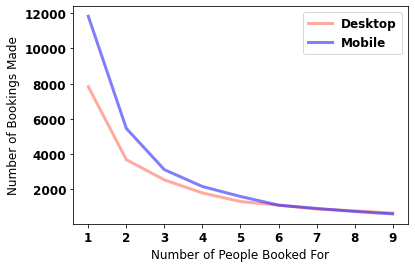

In [129]:
rc('font', weight='bold')
plt.plot(desktop_data_net.groupby(by=["Net Orders"]).count()["Week"], alpha=0.5, label='Desktop', color='#FF5741', linewidth=3)
plt.plot(mobile_data_net.groupby(by=["Net Orders"]).count()["Week"], alpha=0.5, label='Mobile', color='#0000FD', linewidth=3)
plt.legend()
plt.xlabel("Number of People Booked For")
plt.ylabel("Number of Bookings Made")
# plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
# plt.title("Histogram of Correlation Coefficients of Variance of \n the Heart Rates of Instances in Cohort 1 and Cohort 2")
# plt.xticks(rotation = 45)

Text(0, 0.5, 'Number of Bookings Made')

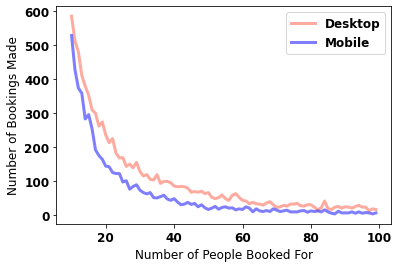

In [130]:
rc('font', weight='bold')
plt.plot(desktop_data_net_large.groupby(by=["Net Orders"]).count()["Week"], alpha=0.5, label='Desktop', color='#FF5741', linewidth=3)
plt.plot(mobile_data_net_large.groupby(by=["Net Orders"]).count()["Week"], alpha=0.5, label='Mobile', color='#0000FD', linewidth=3)
plt.legend()
plt.xlabel("Number of People Booked For")
plt.ylabel("Number of Bookings Made")
# plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
# plt.title("Histogram of Correlation Coefficients of Variance of \n the Heart Rates of Instances in Cohort 1 and Cohort 2")
# plt.xticks(rotation = 45)

In [161]:
with pd.ExcelWriter('separated_data.xlsx') as writer:  
    desktop_data.to_excel(writer, sheet_name='desktop')
    mobile_data.to_excel(writer, sheet_name='mobile')
    mobile_web_data.to_excel(writer, sheet_name='mobile_web')
    mobile_app_data.to_excel(writer, sheet_name='mobile_app')